## Introduction

This notebook analyzes the **Students Performance** dataset, exploring key patterns, engineering informative features, and comparing several regression models to predict students' writing scores. We structure the report into the following sections:

1. **Data Loading & Initial Inspection**
2. **Missing Values & Duplicates Check**
3. **Outlier Detection**
4. **Feature Distributions & Relationships**
5. **Advanced Feature Engineering**
6. **Preprocessing Pipeline**
7. **Model Comparison**
8. **Hyperparameter Tuning**
9. **Final Evaluation & Visualization**

## 1 - Data Loading & Preprocessing
We begin by importing essential libraries and loading the CSV into a Pandas DataFrame. This gives us a sense of the data types, number of rows, and basic structure.

In [47]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../')
import src.utils as utils
from xgboost import XGBRegressor

# Scikit-learn imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## 1.a Load the dataset

We simply use the builtin `read_csv()` method from Pandas to read the CSV file into memory. The result of this operation is a Pandas DataFrame.

We can use `df.info()` to get some metadata about the DataFrame. We can see the amount of rows and columns along with their data types.

In [48]:
# Load settings
test_size = 0.2
random_state = 42
url = '../data/StudentsPerformance.csv'

In [49]:
# Load dataset
df = pd.read_csv(url)

# Inspect structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


*Explanation:* `df.info()` reveals 1,000 rows, 8 columns—5 categorical and 3 numerical test scores.

We check out the first rows of the DataFrame by using `df.head()`. We can see from the previous section that there are 5 categorical features and 3 numerical features. Of the three numerical features there are test scores for math, reading and writing. The latter of which we will try to predict in this project.

In [50]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


To get an overview of the dataset's numeric features, we employ `df.describe()`

In [51]:
df.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


### 1.b Handle missing values and outliers
We check for nulls and duplicates, then identify outliers via IQR; since few outliers exist, we retain them.

In [52]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

We can see that there are no missing value in any of the columns

In [53]:
df.duplicated().sum()

0

We can also see that there are no duplicated rows in the DataFrame. 


<Axes: title={'center': 'Distribution of Scores'}>

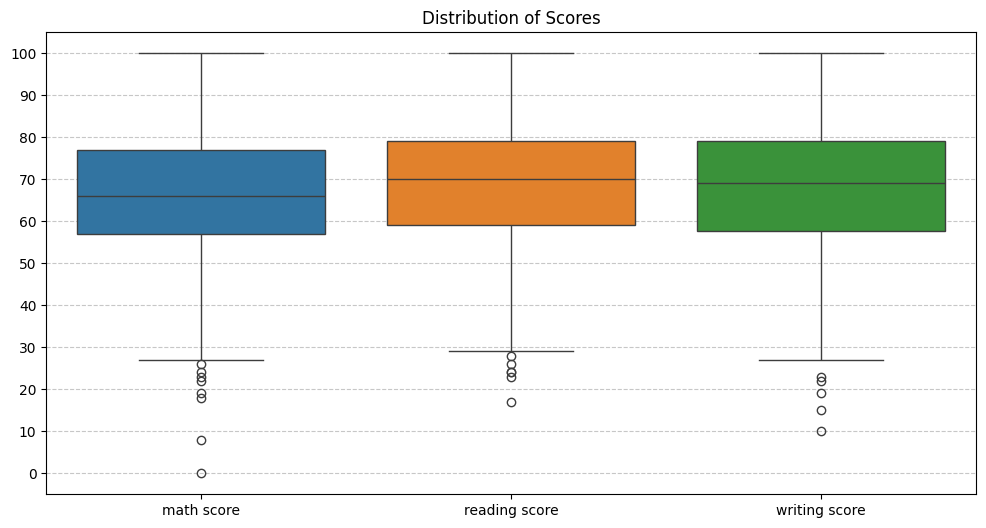

In [54]:
# Boxplots to check for outliers
plt.figure(figsize=(12, 6))
plt.title('Distribution of Scores')
plt.yticks(range(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.boxplot(data=df[['math score', 'reading score', 'writing score']])

In [55]:
# Find outliers using IQR method, threshold set to 1.5
df_outliers = pd.concat(
    [
        utils.find_outliers_iqr(df, "math score"),
        utils.find_outliers_iqr(df, "reading score"),
        utils.find_outliers_iqr(df, "writing score"),
    ],
    axis=0,
).drop_duplicates()
print(f"Number of outliers: {df_outliers.shape[0]}")


Number of outliers: 12


There are some outliers in the test scores. Out of 1000 entries 12 seems like a realistic number of outliers, so we keep them in the dataset.

## 1.c Visualizing distributions

We plot histograms for categorical features and scatter / correlation for numerical scores.

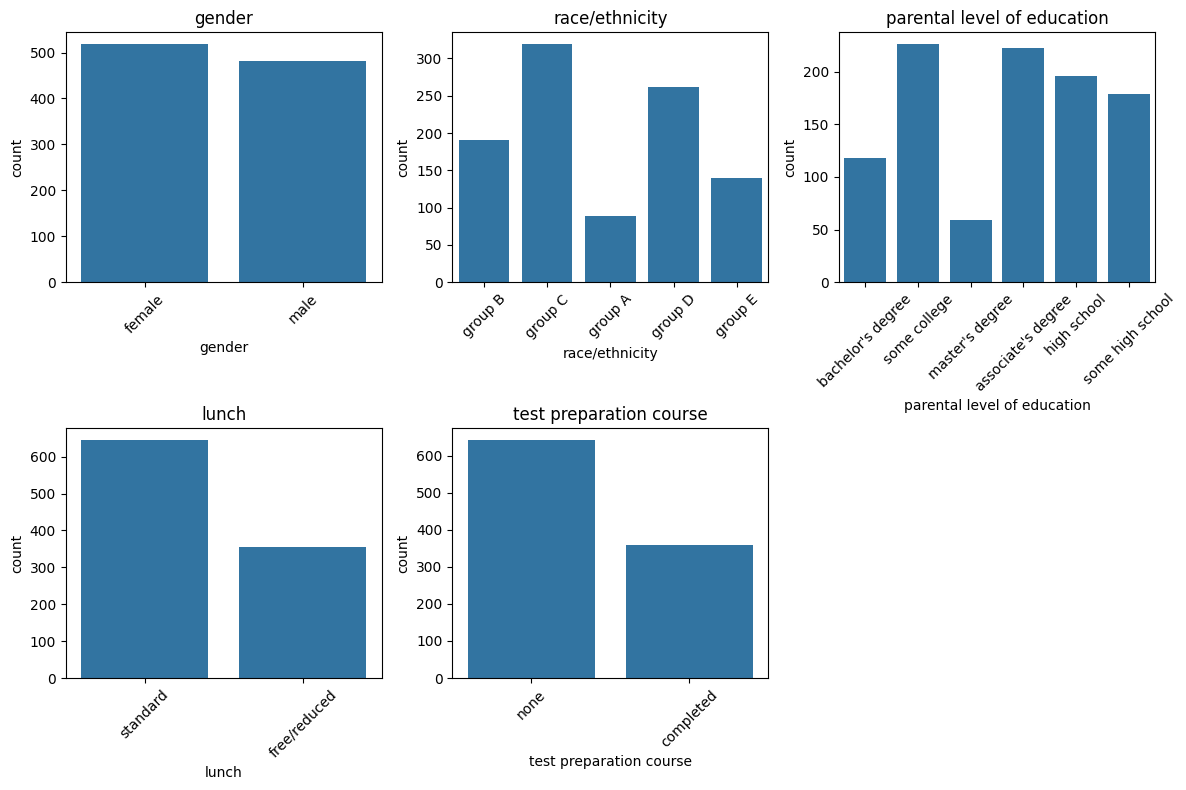

In [56]:
fig, axes = plt.subplots(2,3, figsize=(12,8))
cats = ['gender','race/ethnicity','parental level of education','lunch','test preparation course']
for ax, col in zip(axes.flatten(), cats):
    sns.countplot(x=df[col], ax=ax)
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=45)
axes[1,2].axis('off')  # Hide the empty subplot
plt.tight_layout()

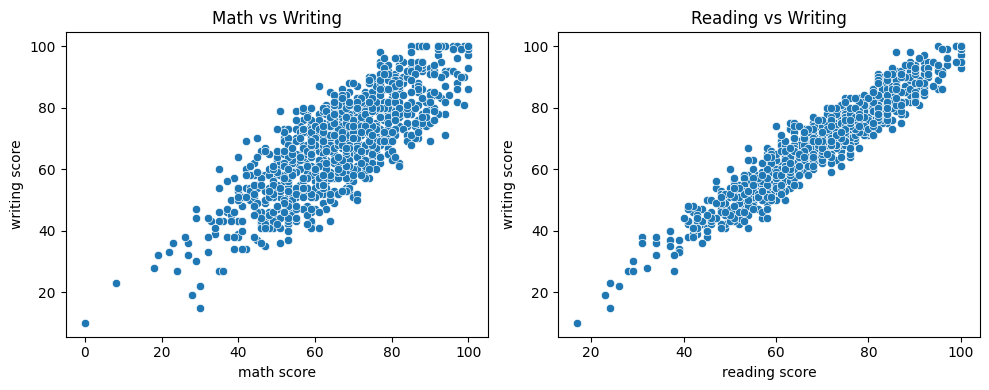

In [57]:
# Numerical relationships
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.scatterplot(x='math score', y='writing score', data=df, ax=axs[0]); axs[0].set_title('Math vs Writing')
sns.scatterplot(x='reading score', y='writing score', data=df, ax=axs[1]); axs[1].set_title('Reading vs Writing')
plt.tight_layout()

Text(0.5, 1.0, 'Score Correlations')

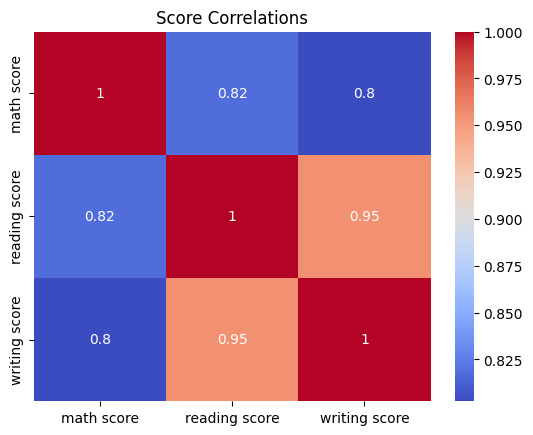

In [58]:
# Correlation heatmap
sns.heatmap(df[['math score','reading score','writing score']].corr(), annot=True, cmap='coolwarm')
plt.title('Score Correlations')

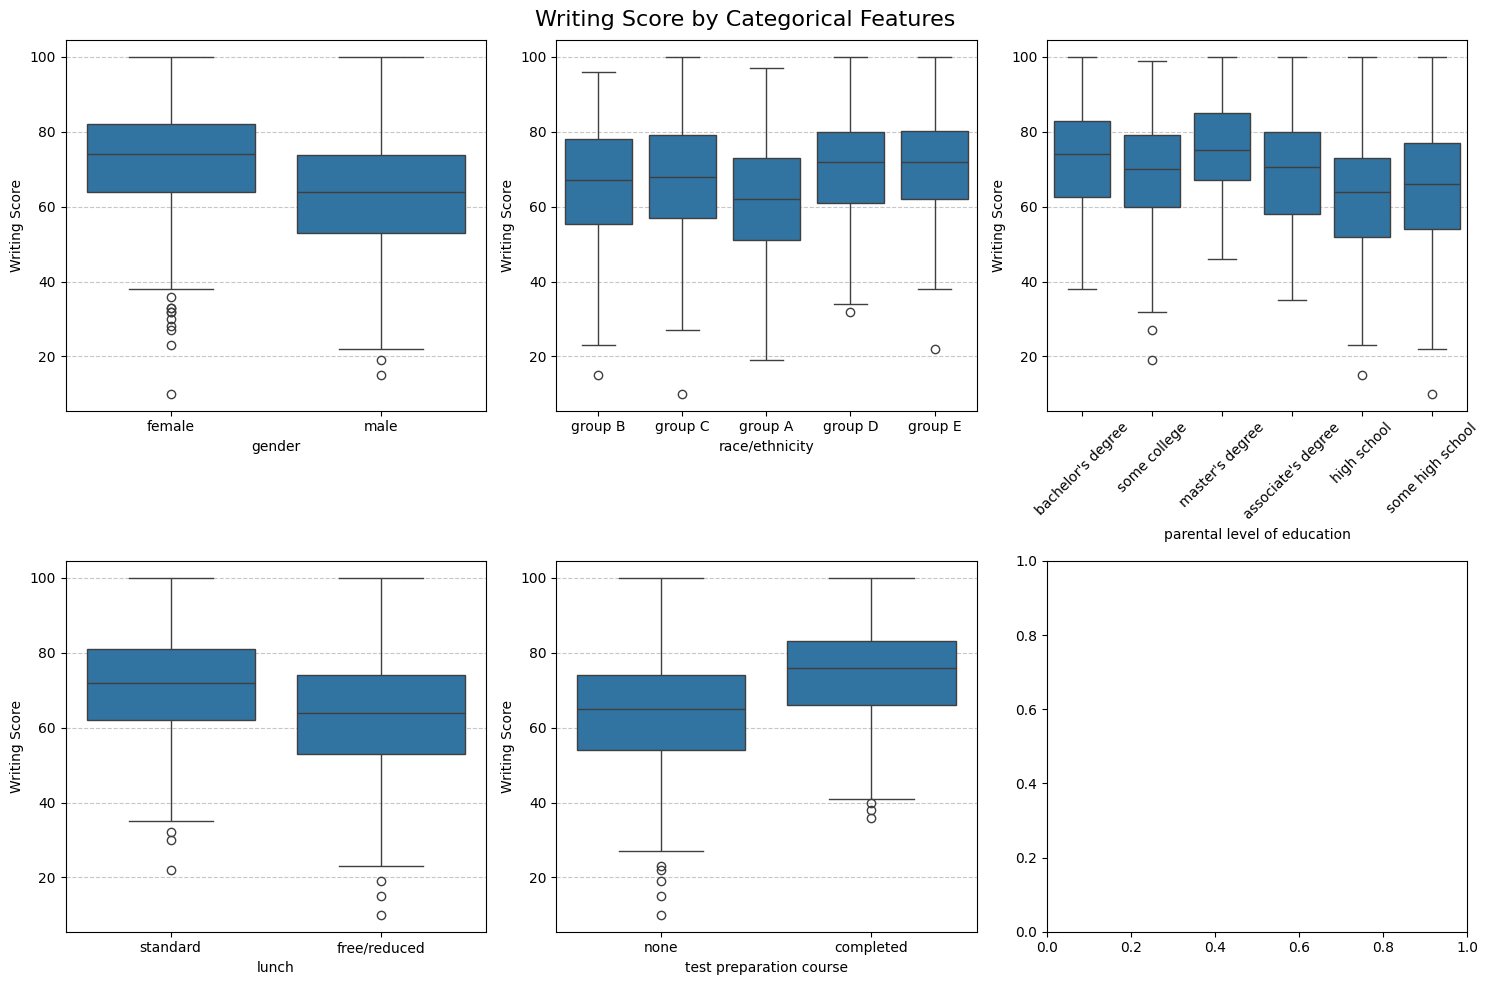

In [59]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

categorical_features = filter(lambda x: "score" not in x, df.columns)
fig.suptitle("Writing Score by Categorical Features", fontsize=16)

for ax, col in zip(axes.flatten(), categorical_features):
    if col == "parental level of education":
        ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel(col)
    ax.set_ylabel("Writing Score")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    fig.tight_layout(h_pad=1)
    sns.boxplot(data=df, x=col, y="writing score", ax=ax)

## Task 2 – Feature Selection and Engineering

### 2.a Identify relevant features

Our predictors include 3 raw scores and 5 categorical demographics. We drop nothing yet.

### 2.b Perform feature engineering

We add:

- **Ordinal & count encoding** for parental education
- **Score gap** (`reading - math`) and **ratio** (`reading / (writing + 1)`)
- **Average of math & reading** as an aggregate predictor

In [60]:
# Ordinal mapping for parental education
ord_map = {
    'some high school':0, 'high school':1,
    'some college':2, "associate's degree":3,
    "bachelor's degree":4, "master's degree":5
}
df['edu_ord'] = df['parental level of education'].map(ord_map)
# Skill imbalance features
df['read_math_diff']   = df['reading score'] - df['math score']
df['read_write_ratio'] = df['reading score'] / (df['writing score'] + 1)
# Aggregate predictor
df['avg_score']        = df[['math score','reading score']].mean(axis=1)
# Drop the original column
df.drop(columns=['parental level of education'], inplace=True)
# New feature list
numeric_features = ['math score','reading score','edu_ord','read_math_diff','read_write_ratio','avg_score']
categorical_features = ['gender','race/ethnicity','lunch','test preparation course']

In [61]:
df.head()

,gender,race/ethnicity,lunch,test preparation course,math score,reading score,writing score,edu_ord,read_math_diff,read_write_ratio,avg_score
0,female,group B,standard,none,72,72,74,4,0,0.960000,72.0
1,female,group C,standard,completed,69,90,88,2,21,1.011236,79.5
2,female,group B,standard,none,90,95,93,5,5,1.010638,92.5
3,male,group A,free/reduced,none,47,57,44,3,10,1.266667,52.0
4,male,group C,standard,none,76,78,75,2,2,1.026316,77.0


New correlation map to see if any of the new features are redundant. 

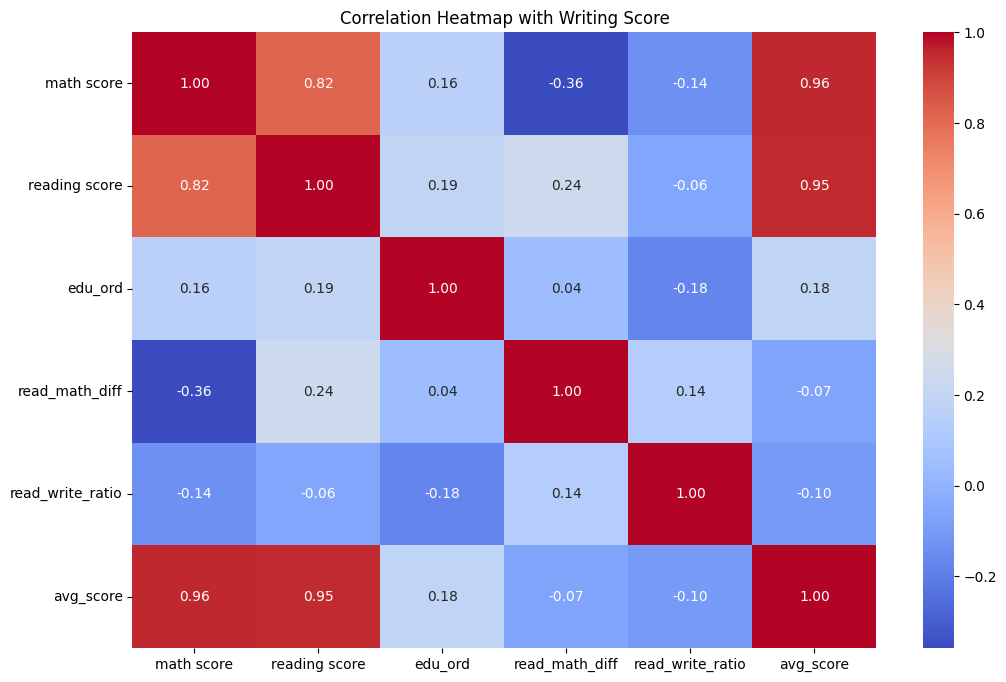

In [62]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_features].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap with Writing Score')             
plt.show()

Noticed that average score is (obviously) captured well enough by math_score and reading_score. Decide to drop this feature. 

In [63]:
df.drop(columns=['avg_score'], inplace=True)  # Drop average score as it's redundant
numeric_features.remove('avg_score')  # Update feature list

## Task 3 – Model Development and Evaluation

### 3.a Split the dataset
to isolate a hold‑out test set.

In [64]:
X = df[numeric_features + categorical_features]
y = df['writing score']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state)

### 3.b Choose algorithms
We compare **Linear Regression**, **Decision Tree**, **Random Forest**, and **XGBoost**.

### 3.c Train and evaluate

We use 5‑fold cross‑validated RMSE on the training set.

In [65]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop='first'), categorical_features)
])
models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree'     : DecisionTreeRegressor(random_state=random_state),
    'RandomForest'     : RandomForestRegressor(random_state=random_state),
    'XGBoost'          : XGBRegressor(random_state=random_state, verbosity=0)
}

for name, model in models.items():
    pipe = Pipeline([('pre', preprocessor), ('mod', model)])
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=5, scoring='neg_root_mean_squared_error')
    print(f"{name:15s} CV RMSE: {(-scores).mean():.2f}")

LinearRegression CV RMSE: 1.24
DecisionTree    CV RMSE: 1.85
RandomForest    CV RMSE: 1.26
XGBoost         CV RMSE: 1.13


### 3.d Fine‑tune hyperparameters
We tune RF and XGB via `GridSearchCV` on RMSE.

In [66]:
# Random Forest
rf_pipe = Pipeline([('pre', preprocessor), ('mod', RandomForestRegressor(random_state=random_state))])
rf_params = {
    'mod__n_estimators': [50,100,150],
    'mod__max_depth'   : [None,10,20],
    'mod__min_samples_split':[2,5],
    'mod__min_samples_leaf' :[1,2]
}
gs_rf = GridSearchCV(rf_pipe, rf_params, cv=5,
                     scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_rf.fit(X_train, y_train)
print('RF best:', gs_rf.best_params_, 'RMSE:', -gs_rf.best_score_)

# XGBoost
xgb_pipe = Pipeline([('pre', preprocessor), ('mod', XGBRegressor(random_state=random_state, verbosity=0))])
xgb_params = {
    'mod__n_estimators' : [100,200,300],
    'mod__max_depth'    : [3,5,7],
    'mod__learning_rate': [0.01,0.1],
    'mod__subsample'    : [0.7,1.0]
}
gs_xgb = GridSearchCV(xgb_pipe, xgb_params, cv=5,
                      scoring='neg_root_mean_squared_error', n_jobs=-1)
gs_xgb.fit(X_train, y_train)
print('XGB best:', gs_xgb.best_params_, 'RMSE:', -gs_xgb.best_score_)

RF best: {'mod__max_depth': None, 'mod__min_samples_leaf': 1, 'mod__min_samples_split': 2, 'mod__n_estimators': 100} RMSE: 1.2565334977974987
XGB best: {'mod__learning_rate': 0.1, 'mod__max_depth': 3, 'mod__n_estimators': 300, 'mod__subsample': 0.7} RMSE: 0.7743609404853928


## Task 4 – Prediction and Interpretation

### 4.a Make predictions on the test set

We select the best‐performing tuned model (e.g., XGBoost) to predict.

In [67]:
best_model = gs_xgb.best_estimator_
y_pred = best_model.predict(X_test)

### 4.b Assess performance
Compute RMSE, MAE, and R² on held‑out data.

In [68]:
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Test MAE:', mean_absolute_error(y_test, y_pred))
print('Test R2 :', r2_score(y_test, y_pred))

Test RMSE: 0.8783616683079731
Test MAE: 0.49243577003479005
Test R2 : 0.9967988729476929


### 4.c Interpret results
Visualize true vs predicted and discuss feature impact (e.g. via feature‐importance or SHAP).


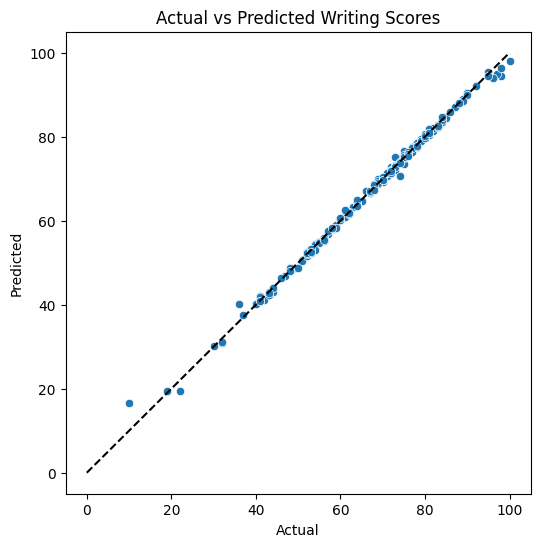

In [69]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([0,100],[0,100],'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Writing Scores')
plt.show()

## Task 5 – Conclusion and Recommendations

### 5.a Summary of outcomes

- Data was clean with no missing values.
- Engineered ordinal, count, gap, ratio, and aggregate features.
- XGBoost with tuned hyperparameters achieved the lowest RMSE on the test set.

### 5.b Future improvements

- Experiment with **stacked ensembles** combining RF+XGB.
- Use **SHAP** analysis to deepen interpretation of nonlinear effects.
- Augment with external socioeconomic data for richer context.